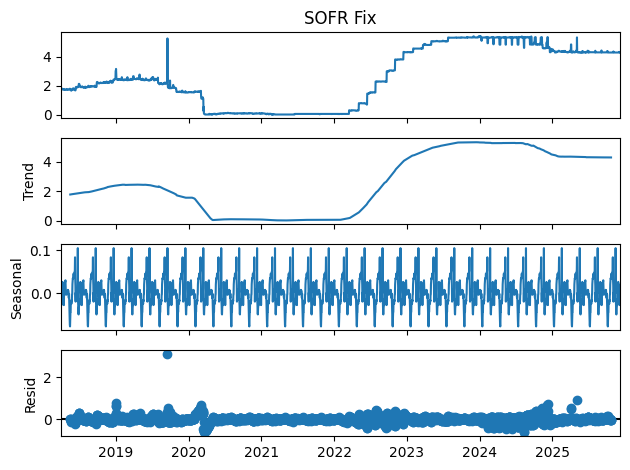

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --- Load and Clean Data ---
# Adjust skiprows as needed to reach the actual data header
raw = pd.read_csv('Repo_data.csv', skiprows=10, header=None)

# Find the first row with 'Date' in any column, use as header
header_row = None
for i, row in raw.iterrows():
    if any(str(cell).strip().lower() == 'date' for cell in row):
        header_row = i
        break

# Reload with correct header
df = pd.read_csv('Repo_data.csv', skiprows=header_row)
df.columns = [str(c).strip() for c in df.columns]

# Rename columns if needed
if 'Date' not in df.columns:
    for col in df.columns:
        if 'date' in col.lower():
            df = df.rename(columns={col: 'Date'})
if 'SOFR Fix' not in df.columns:
    for col in df.columns:
        if 'sofr' in col.lower():
            df = df.rename(columns={col: 'SOFR Fix'})

# Keep only Date and SOFR Fix, drop missing
df = df[['Date', 'SOFR Fix']].dropna()

# Parse dates
def parse_date(x):
    for fmt in ('%d-%m-%Y', '%Y-%m-%d', '%m/%d/%y', '%d/%m/%Y', '%m-%d-%Y', '%d-%b-%y', '%d/%m/%y', '%Y/%m/%d'):
        try:
            return pd.to_datetime(x, format=fmt)
        except Exception:
            continue
    return pd.to_datetime(x, errors='coerce')

df['Date'] = df['Date'].apply(parse_date)
df = df.dropna(subset=['Date'])
df = df.sort_values('Date')
df = df.set_index('Date')

# Handle duplicate dates by grouping and taking the mean
df = df.groupby(df.index).mean()

# Convert SOFR Fix to float
df['SOFR Fix'] = df['SOFR Fix'].astype(str).str.replace(',', '').astype(float)

# Resample to daily frequency, forward fill missing days
df = df.resample('D').ffill()

# --- Seasonal Decomposition ---
# Set period=365 for yearly seasonality (adjust if you want weekly: period=7)
decomposition = sm.tsa.seasonal_decompose(df['SOFR Fix'], model='additive', period=90)
fig = decomposition.plot()
plt.tight_layout()
plt.show()

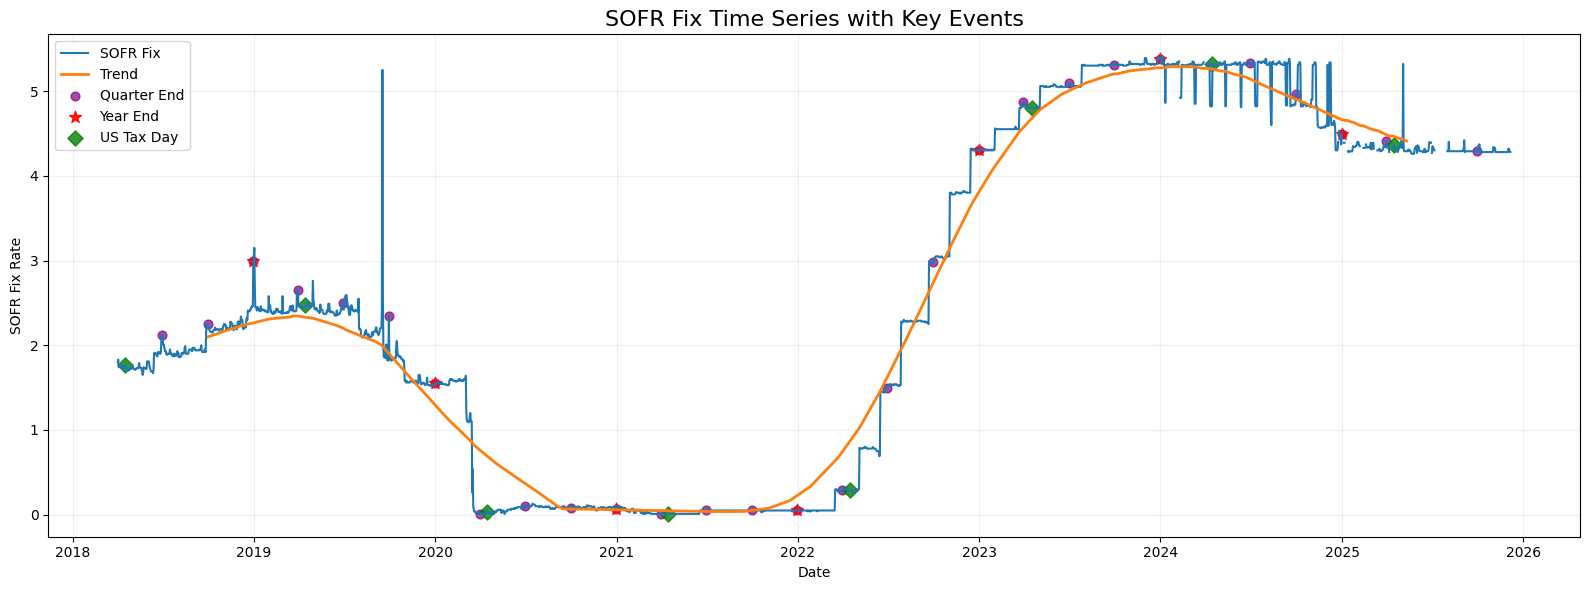

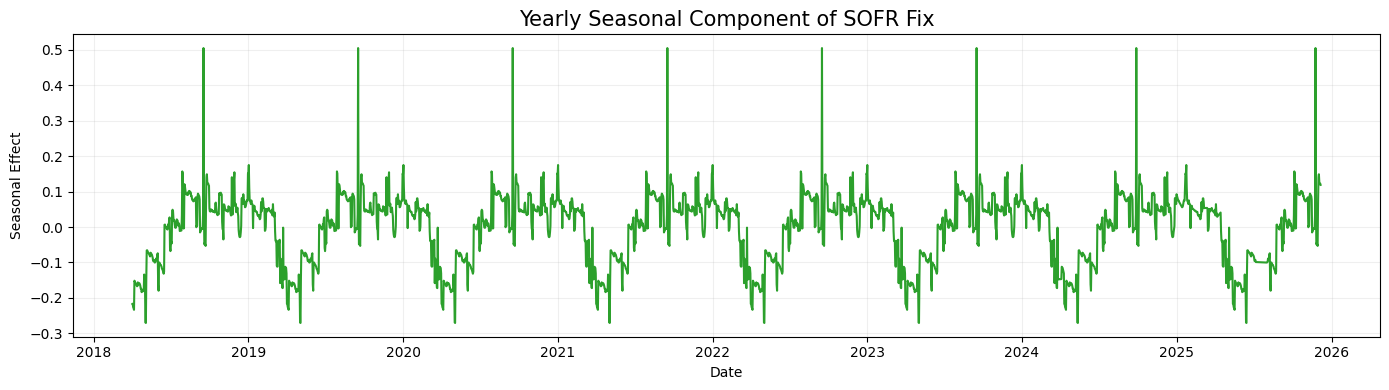

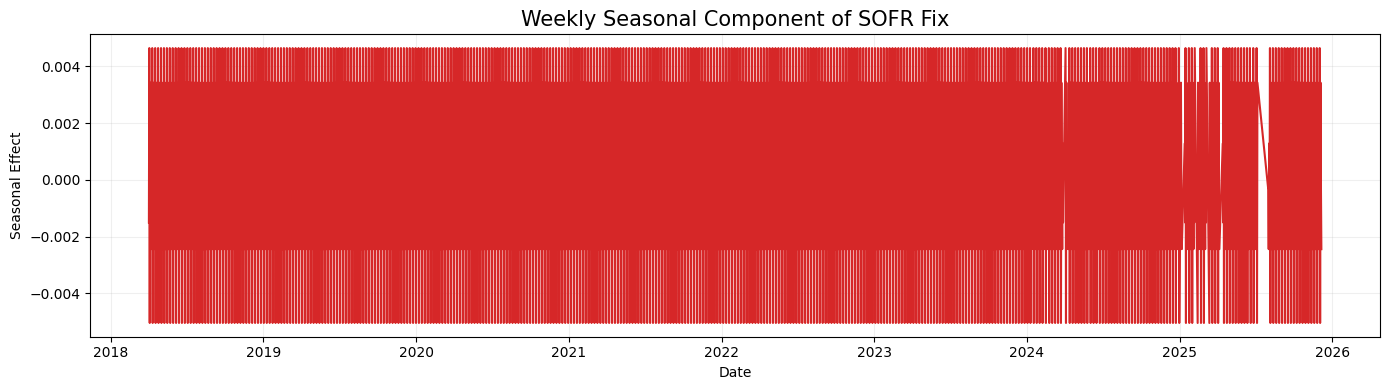

<Figure size 1200x600 with 0 Axes>

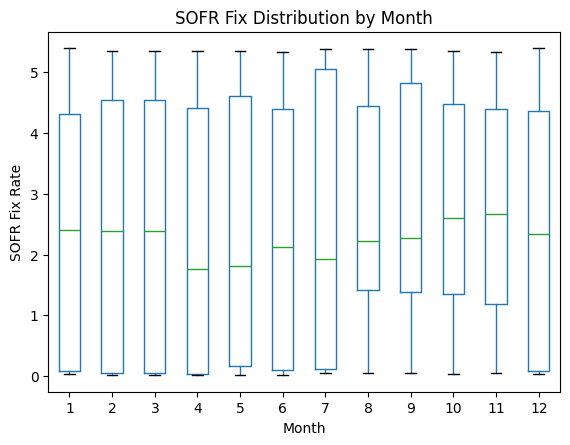

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.tseries.offsets import BDay

# --- Load and Clean Data ---
# Adjust skiprows to reach the actual data header
file = 'Repo_data.csv'
raw = pd.read_csv(file, header=None)
header_row = None
for i, row in raw.iterrows():
    if any(str(cell).strip().lower() == 'date' for cell in row):
        header_row = i
        break
df = pd.read_csv(file, skiprows=header_row)
df.columns = [str(c).strip() for c in df.columns]
if 'Date' not in df.columns:
    for col in df.columns:
        if 'date' in col.lower():
            df = df.rename(columns={col: 'Date'})
sofr_col = [col for col in df.columns if 'sofr' in col.lower() and 'fix' in col.lower()][0]
def parse_date(x):
    for fmt in ('%d-%m-%Y', '%Y-%m-%d', '%m/%d/%y', '%d/%m/%Y', '%m-%d-%Y', '%d-%b-%y', '%d/%m/%y', '%Y/%m/%d'):
        try:
            return pd.to_datetime(x, format=fmt)
        except Exception:
            continue
    return pd.to_datetime(x, errors='coerce')
df['Date'] = df['Date'].apply(parse_date)
df = df.dropna(subset=['Date']).sort_values('Date').drop_duplicates(subset=['Date']).set_index('Date')
sofr = pd.to_numeric(df[sofr_col].astype(str).str.replace(',', '').replace('N/A', np.nan).replace('#VALUE!', np.nan), errors='coerce')
sofr = sofr.resample('D').ffill()

# --- Event Markers ---
seasonal_df = pd.DataFrame({'SOFR Fix': sofr})
seasonal_df['is_quarter_end'] = seasonal_df.index.is_quarter_end.astype(int)
seasonal_df['is_year_end'] = seasonal_df.index.is_year_end.astype(int)
def us_tax_day(year):
    d = pd.Timestamp(f'{year}-04-15')
    if d.weekday() >= 5:
        d = d + BDay(1)
    return d
tax_days = [us_tax_day(y) for y in range(seasonal_df.index.year.min(), seasonal_df.index.year.max()+1)]
seasonal_df['is_tax_day'] = seasonal_df.index.isin(tax_days).astype(int)

# Drop NaNs from 'SOFR Fix' before decomposition
sofr_for_decomposition = seasonal_df['SOFR Fix'].dropna()

# --- Seasonal Decomposition ---
decomposition = sm.tsa.seasonal_decompose(sofr_for_decomposition, model='additive', period=365)
seasonal = decomposition.seasonal
trend = decomposition.trend
resid = decomposition.resid

# --- Plot 1: SOFR Fix with Event Markers ---
plt.figure(figsize=(16,6))
plt.plot(seasonal_df.index, seasonal_df['SOFR Fix'], label='SOFR Fix', color='#1f77b4')
plt.plot(trend.index, trend, label='Trend', color='#ff7f0e', linewidth=2)
plt.title('SOFR Fix Time Series with Key Events', fontsize=16)
plt.ylabel('SOFR Fix Rate')
plt.xlabel('Date')
# Highlight quarter-end
plt.scatter(seasonal_df.index[seasonal_df['is_quarter_end'] == 1], seasonal_df['SOFR Fix'][seasonal_df['is_quarter_end'] == 1],
            color='purple', marker='o', label='Quarter End', s=40, alpha=0.7)
# Highlight year-end
plt.scatter(seasonal_df.index[seasonal_df['is_year_end'] == 1], seasonal_df['SOFR Fix'][seasonal_df['is_year_end'] == 1],
            color='red', marker='*', label='Year End', s=80, alpha=0.9)
# Highlight US tax days
plt.scatter(seasonal_df.index[seasonal_df['is_tax_day'] == 1], seasonal_df['SOFR Fix'][seasonal_df['is_tax_day'] == 1],
            color='green', marker='D', label='US Tax Day', s=60, alpha=0.8)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# --- Plot 2: Yearly Seasonal Component ---
plt.figure(figsize=(14,4))
plt.plot(seasonal.index, seasonal, color='#2ca02c')
plt.title('Yearly Seasonal Component of SOFR Fix', fontsize=15)
plt.ylabel('Seasonal Effect')
plt.xlabel('Date')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# --- Plot 3: Weekly Seasonal Component ---
# Decompose for weekly seasonality
decomp_week = sm.tsa.seasonal_decompose(sofr_for_decomposition, model='additive', period=7)
plt.figure(figsize=(14,4))
plt.plot(decomp_week.seasonal.index, decomp_week.seasonal, color='#d62728')
plt.title('Weekly Seasonal Component of SOFR Fix', fontsize=15)
plt.ylabel('Seasonal Effect')
plt.xlabel('Date')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# --- Plot 4: Boxplot by Month (Seasonal Distribution) ---
seasonal_df['month'] = seasonal_df.index.month
plt.figure(figsize=(12,6))
seasonal_df.boxplot(column='SOFR Fix', by='month', grid=False, boxprops=dict(color='#1f77b4'))
plt.title('SOFR Fix Distribution by Month')
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('SOFR Fix Rate')
plt.show()